### coupling rates
#### Tom Schatteburg, 26.11.2023
calculate some (unnormalized) coupling rates from some forcing function to some fields from DASE

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import overlap_integrals as oi
from scipy.interpolate import CloughTocher2DInterpolator

In [2]:
cylRad = 200e-6
infilename = fr"E:\UserData\polyboxPHD\Projects\transduction_simulations\DASE\output_array_r_cylRad{cylRad/1e-6:.0f}um.txt"

In [51]:
infiledata = np.loadtxt(infilename, delimiter=',', skiprows=1)
downsample_fact = 20
rs = infiledata[::downsample_fact,0]
Psis_r = infiledata[::downsample_fact,1:]
Psis_r = Psis_r / np.max(abs(Psis_r), axis=0) * np.sign(Psis_r[0,:])
ks = np.arange(0, len(Psis_r[0,:]))

In [52]:
forcing_Rad = 30e-6

In [53]:
@np.vectorize
def forcing_func_cyl(r, R):
    return 1.0 * (r <= R)

### set up fields using polar coordinates

In [54]:
Rmax = rs[-1]
phis = np.linspace(0, 2*np.pi, 102, endpoint=False)
rg, phig = np.meshgrid(rs, phis, indexing='ij')

In [43]:
forcing_field = oi.field(forcing_func_cyl(rg, forcing_Rad), coordinates = {'r': rs, 'phi': phis})

In [44]:
mech_fields = [oi.field(np.meshgrid(Psis_r[:,i],phis,indexing='ij')[0], coordinates = {'r': rs, 'phi': phis}) for i in range(Psis_r.shape[1])]

In [55]:
forcing_field = oi.field(forcing_func_cyl(rg, forcing_Rad), coordinates = {'r': rs, 'phi': phis}).normalize_abs2()

In [56]:
mech_fields = [oi.field(np.meshgrid(Psis_r[:,i],phis,indexing='ij')[0], coordinates = {'r': rs, 'phi': phis}).normalize_abs2() for i in range(Psis_r.shape[1])]

plot fields

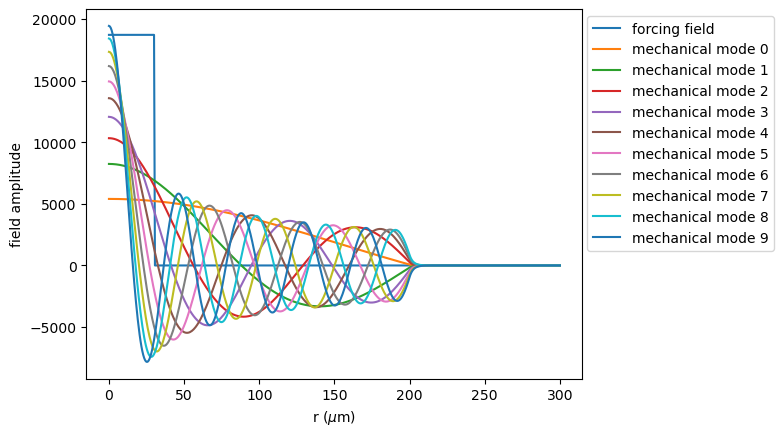

In [57]:
plt.plot(rs/1e-6, forcing_field.values[:,0], label='forcing field')
for k in ks:
    plt.plot(rs/1e-6, mech_fields[k].values[:,0], label=f'mechanical mode {k}')
plt.xlabel(r'r ($\mu$m)')
plt.ylabel('field amplitude')
plt.legend( loc='upper right', bbox_to_anchor=(1.4, 1.0))
plt.show()

In [63]:
[(abs(field)**2).integrate_all_dimensions() for field in [forcing_field] + mech_fields]

[0.9999999999999998,
 0.999999999999999,
 1.0000000000000009,
 0.9999999999999997,
 0.9999999999999986,
 0.9999999999999982,
 0.9999999999999999,
 1.0000000000000004,
 0.9999999999999997,
 0.9999999999999994,
 0.9999999999999984]

overlaps

In [58]:
overlaps = np.array([forcing_field.overlap(mech_field) for mech_field in mech_fields])

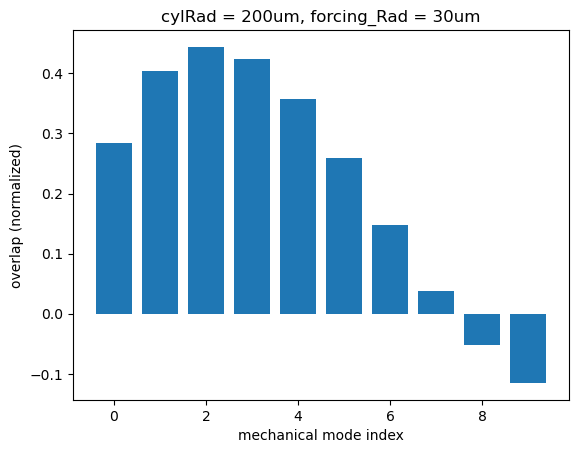

In [61]:
plt.bar(ks,overlaps)
plt.title(f'cylRad = {cylRad/1e-6:.0f}um, forcing_Rad = {forcing_Rad/1e-6:.0f}um')
plt.xlabel('mechanical mode index')
plt.ylabel('overlap (normalized)')
plt.show()

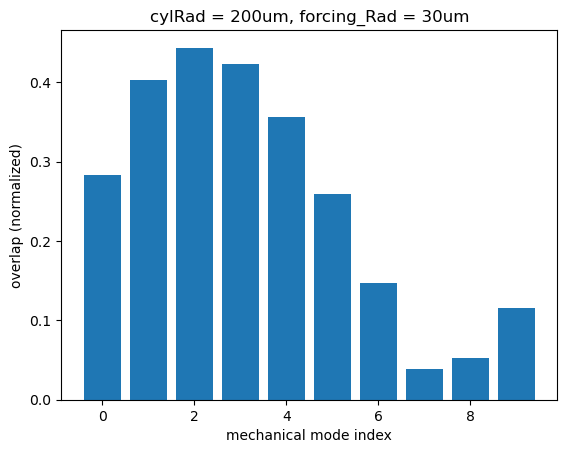

In [60]:
plt.bar(ks,abs(overlaps))
plt.title(f'cylRad = {cylRad/1e-6:.0f}um, forcing_Rad = {forcing_Rad/1e-6:.0f}um')
plt.xlabel('mechanical mode index')
plt.ylabel('overlap (normalized)')
plt.show()

In [27]:
sum(abs(overlaps)**2)

0.8536600976004299

### using cartesian coordinates

In [14]:
xs = np.linspace(-Rmax, Rmax, 100)
ys = np.linspace(-Rmax, Rmax, 103)
xg, yg = np.meshgrid(xs, ys, indexing='ij')

In [15]:
forcing_field_xy = oi.field(forcing_func_cyl(np.sqrt(xg**2+yg**2), forcing_Rad), coordinates = {'x': xs, 'y': ys})

In [16]:
mech_fields_xy = np.empty(shape=len(ks), dtype=oi.field)
for k in ks:
    interp = CloughTocher2DInterpolator(list(zip((rg*np.cos(phig)).flat,(rg*np.sin(phig)).flat)), np.meshgrid(Psis_r[:,k],phis,indexing='ij')[0].flat)
    mech_fields_xy[k] = oi.field(np.nan_to_num(interp(xg,yg),nan=0.0), coordinates = {'x': xs, 'y': ys})

In [28]:
forcing_field_xy = oi.field(forcing_func_cyl(np.sqrt(xg**2+yg**2), forcing_Rad), coordinates = {'x': xs, 'y': ys}).normalize_abs2()

In [29]:
mech_fields_xy = np.empty(shape=len(ks), dtype=oi.field)
for k in ks:
    interp = CloughTocher2DInterpolator(list(zip((rg*np.cos(phig)).flat,(rg*np.sin(phig)).flat)), np.meshgrid(Psis_r[:,k],phis,indexing='ij')[0].flat)
    mech_fields_xy[k] = oi.field(np.nan_to_num(interp(xg,yg),nan=0.0), coordinates = {'x': xs, 'y': ys}).normalize_abs2()

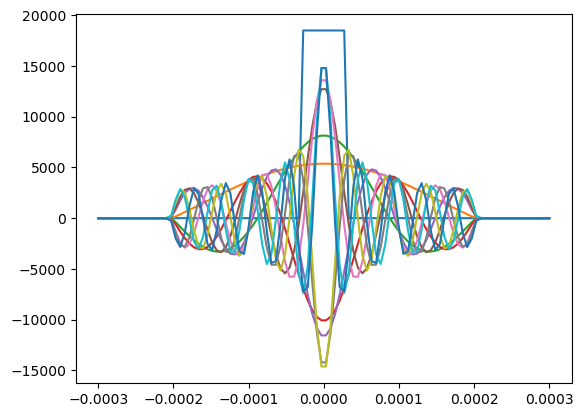

In [30]:
plt.plot(xs, forcing_field_xy.values[:,50])
for k in ks:
    plt.plot(xs, mech_fields_xy[k].values[:,50])

In [31]:
overlaps_xy = np.array([forcing_field_xy.overlap(mech_field_xy) for mech_field_xy in mech_fields_xy])

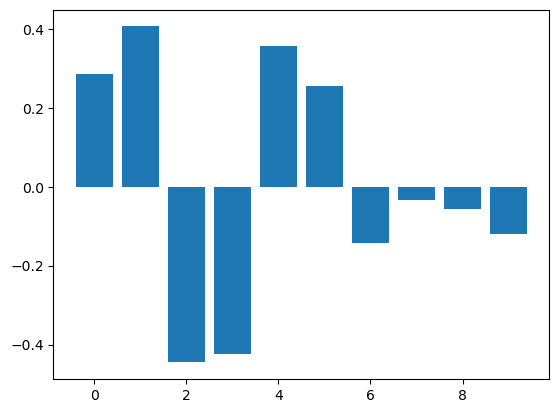

In [32]:
plt.bar(ks,overlaps_xy)
plt.show()

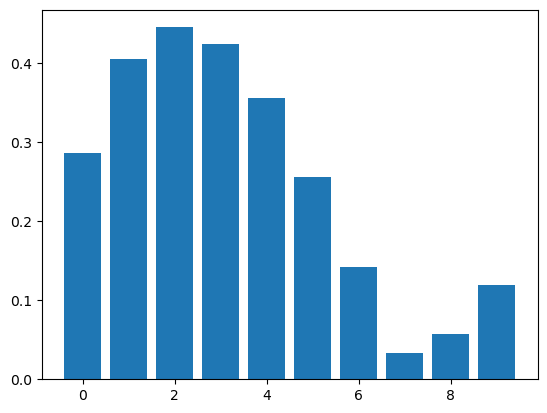

In [33]:
plt.bar(ks,abs(overlaps_xy))
plt.show()

In [36]:
sum(abs(overlaps_xy)**2)

0.8557233232926462